# Lab 3: final challenges

__Вам предлагается решить задачу классификации сигналов (вы уже встречались с ней во второй лабораторной работе) или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


In [0]:
import time

import natsort

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

import csv

from sklearn.metrics import accuracy_score

from PIL import Image

import torch
import torch.nn as nn
from torch import utils

import torchvision
from torchvision import transforms
from torchvision import models

import torchsummary

from IPython import display

import matplotlib
matplotlib.rcParams.update({'font.size':14})

%matplotlib inline

In [2]:
def LOG(text):
    print(text)
    print('-'*70)

try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    LOG("""Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

WORK_DIR = './'
if USE_COLAB:
    from google.colab import files, drive
    WORK_DIR = '/content/drive/'
    drive.mount(WORK_DIR)
    WORK_DIR += 'My Drive/projects/lab-3-dogs/'
LOG(f"Working directory is {WORK_DIR}")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LOG(f'Using device is {device}')

Don't forget to avoid disconnections:
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    
----------------------------------------------------------------------
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Working directory is /content/drive/My Drive/projects/lab-3-dogs/
----------------------------------------------------------------------
Using device is cuda:0
----------------------------------------

## Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

### Загрузка данных

#### Извлечём изображения

In [4]:
file_name = WORK_DIR + "data.zip"
!unzip "$file_name" > /dev/null
!ls data/
data_path = 'data/'

test  train


#### Изучим размеры картинок

In [0]:
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')
widths = []
heights = []

for target_folder in os.listdir(train_dir):
    target_dir = os.path.join(train_dir, target_folder)
    for image_name in os.listdir(target_dir):
        image_path = os.path.join(target_dir, image_name)
        image = Image.open(image_path)
        widths.append(image.width)
        heights.append(image.height)
widths = np.array(widths)
heights = np.array(heights)

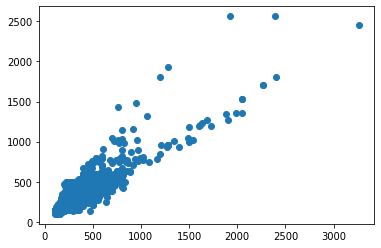

In [6]:
plt.figure()
plt.scatter(widths, heights)
plt.show()

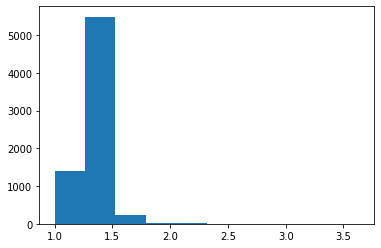

In [7]:
plt.figure()
plt.hist(np.max(np.vstack([widths, heights]), axis=0) / np.min(np.vstack([widths, heights]), axis=0))
plt.show()

#### **Выводы**

Можно заметить, что исходные фотографии различных размеров, причём число тех, у которых высота больше ширины, примерно столько же как и тех, у которых ширина больше высоты. Поэтому наша будущая модель будет принимать квадратное изображение. Размер будет $224 \times 224$

#### Загрузим тестовые данные, а так же поделим их на train/validate

In [8]:
full_train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
)

n = len(full_train_dataset)
train_size = int(n*0.8)
validate_size = n - train_size
train_dataset, validate_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, validate_size])
validate_dataset.dataset.transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
print(f'Length of train dataset is {len(train_dataset)}, should be {train_size}')
print(f'Length of validate dataset is {len(validate_dataset)}, should be {validate_size}')

full_train_loader = torch.utils.data.DataLoader(
    full_train_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset,
    batch_size=128,
    num_workers=0,
    shuffle=True
)

Length of train dataset is 5732, should be 5732
Length of validate dataset is 1434, should be 1434


#### Объявим test_dataset и test_dataloader

In [0]:
class ImageSingleFolder(utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]

In [0]:
test_dataset = ImageSingleFolder(
    main_dir=test_dir,
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

### Определим нейронную сеть

#### Загрузка VGG16

In [0]:
def get_vgg16net(num_classes):
    net = models.vgg16(pretrained=True)
    net.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, num_classes),
    )
    return net

#### Загрузка ResNet18

In [0]:
def get_resnet18(num_classes):
    net = models.resnet18(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузка ResNet34

In [0]:
def get_resnet34(num_classes):
    net = models.resnet34(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузка ResNet50

In [0]:
def get_resnet50(num_classes):
    net = models.resnet50(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузка ResNet50 с зафиксированными слоями

In [0]:
def get_resnet50_fixed(num_classes):
    net = models.resnet50(pretrained=True)
    for param in net.parameters():
        param.requires_grad = False

    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(512, num_classes)
    )
    return net

#### Загрузка GoogleNet

In [0]:
def get_googlenet(num_classes):
    net = models.googlenet(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузим ResNext50

In [0]:
def get_resnext50(num_classes):
    net = models.resnext50_32x4d(pretrained=True)
    num_ftrs = net.fc.in_features

    net.fc = nn.Linear(num_ftrs, num_classes)
    return net

#### Загрузка ResNext50 с зафиксированными слоями

In [0]:
def get_resnext50(num_classes):
    net = models.resnext50_32x4d(pretrained=True)
    
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(512, num_classes)
    )
    return net

#### Класс для обучения

In [0]:
class LearningModel:
    def __init__(self, net, net_name):
        self.net = net
        self.net_name = net_name
        self.optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0
        self.metrics = {'accuracy' : {}, 'loss' : {}}
    
    def predict(self, input):
        return self.net.forward(input).argmax(axis=-1)
    
    def get_acc(self, img_batch, label_batch):
        predictions = self.predict(img_batch)
        return (predictions == label_batch).float().mean()

    def get_loss(self, img_batch, label_batch):
        predictions = self.net.forward(img_batch)
        loss = self.criterion(predictions, label_batch)
        return loss

    def evaluate(self, data_loaders):
        with torch.no_grad():
            for name, data_loader in data_loaders.items():
                metrics_sum = {'accuracy':0., 'loss':0.}
                metrics_func = {'accuracy':self.get_acc, 'loss':self.get_loss}
                total_num = 0.
                for img_batch, label_batch in data_loader:
                    batch_size = img_batch.shape[0]
                    img_batch = img_batch.to(device)
                    label_batch = label_batch.to(device)
                    
                    for k in metrics_sum.keys():
                        metrics_sum[k] += metrics_func[k](img_batch, label_batch) * batch_size
                    
                    total_num += batch_size
                
                for k, v in metrics_sum.items():
                    self.metrics[k].setdefault(name, [])
                    self.metrics[k][name].append(v / total_num)


    def fit(self,
            data_loaders,
            n_epoch=20,
           ):
        self.n_epoch = n_epoch

        while self.epoch <= n_epoch:
            display.clear_output(wait=True)
            self.evaluate(data_loaders)
            self.visualize()
            if self.epoch == n_epoch:
                break

            for img_batch, label_batch in data_loaders['train']:
                img_batch = img_batch.to(device)
                label_batch = label_batch.to(device)

                self.optimizer.zero_grad()
                
                loss = self.get_loss(img_batch, label_batch)
            
                # Backward
                loss.backward()
                
                # Update weights
                self.optimizer.step()
            
            self.epoch += 1

        return self
    
    def visualize_metric(self, ax, metric_name):
        ax.set_title(metric_name)
        ax.set_xlabel('Epoch num')
        ax.set_ylabel(metric_name)

        for k, v in self.metrics[metric_name].items():
            ax.plot(v, label=f'On {k} {metric_name}={v[-1]}')
        
        ax.legend(loc='best')

    def visualize(self, independ_plot=False):
        print('Epoch {}/{}'.format(self.epoch, self.n_epoch))

        fig = plt.figure(figsize=(29.7/2, 21.))

        loss_ax = fig.add_subplot(2, 1, 1)
        acc_ax = fig.add_subplot(2, 1, 2)

        self.visualize_metric(loss_ax, 'loss')
        self.visualize_metric(acc_ax, 'accuracy')
        
        plt.legend(loc='best')
        plt.show()

### Эксперименты с обучением
Для начала выясним при каком числе итерация начинается переобучение

#### Будем обучать ResNet18 на 80% тренировочной выборке, а валидироваться на 20%

In [0]:
resnet18 = get_resnet18(50).to(device)
torchsummary.summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 39/70


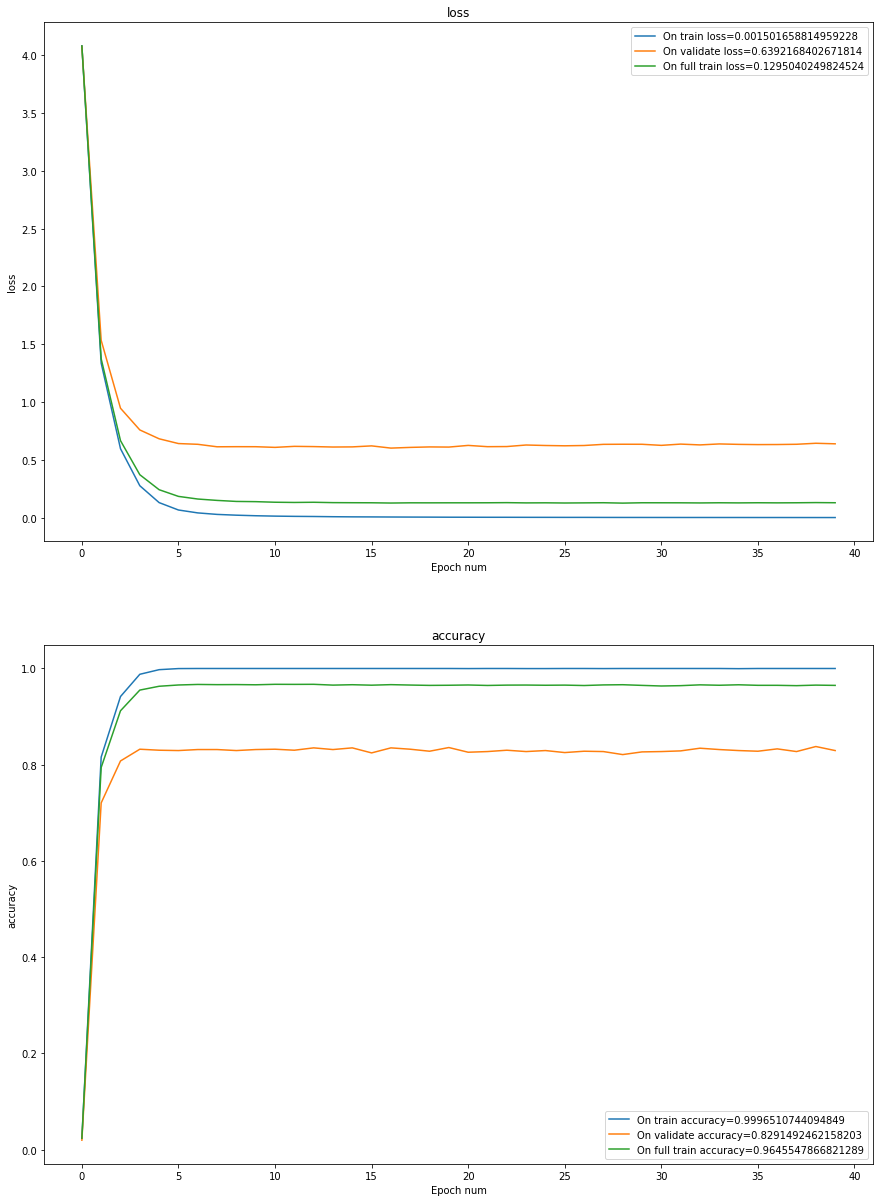

KeyboardInterrupt: ignored

In [0]:
%%time
resnet18_lm = LearningModel(resnet18, 'ResNet18')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
resnet18_lm.fit(dataloaders, n_epoch=70)

#### Попробуем ResNet34

In [0]:
resnet34 = get_resnet34(50).to(device)
torchsummary.summary(resnet34, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 40/40


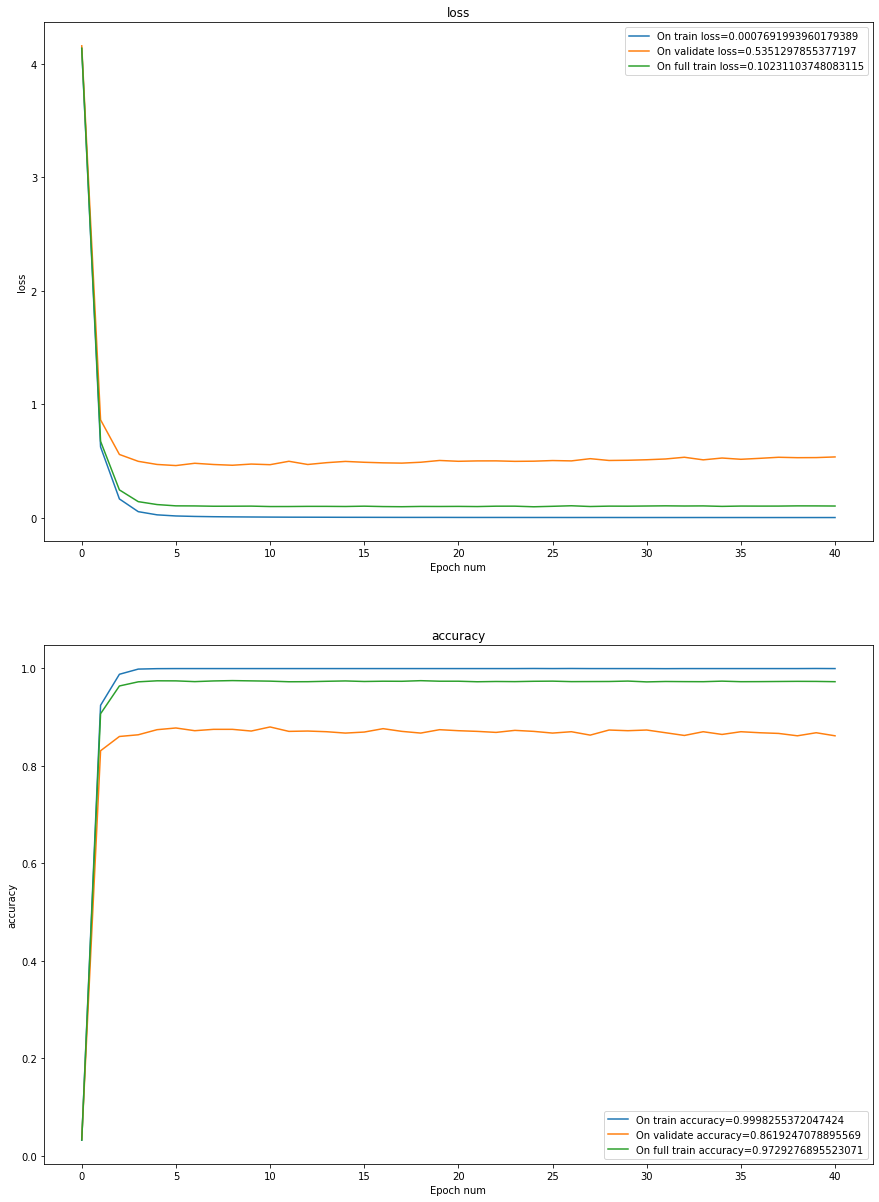

CPU times: user 1h 18min 55s, sys: 11min 13s, total: 1h 30min 9s
Wall time: 1h 30min 13s


In [0]:
%%time
resnet34_lm = LearningModel(resnet34, 'ResNet34')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
resnet34_lm.fit(dataloaders, n_epoch=40)

#### Обучим ResNet 50. Ну а вдруг!

In [0]:
resnet50 = get_resnet50(50).to(device)
torchsummary.summary(resnet50, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256

Epoch 30/30
Epoch 30/30


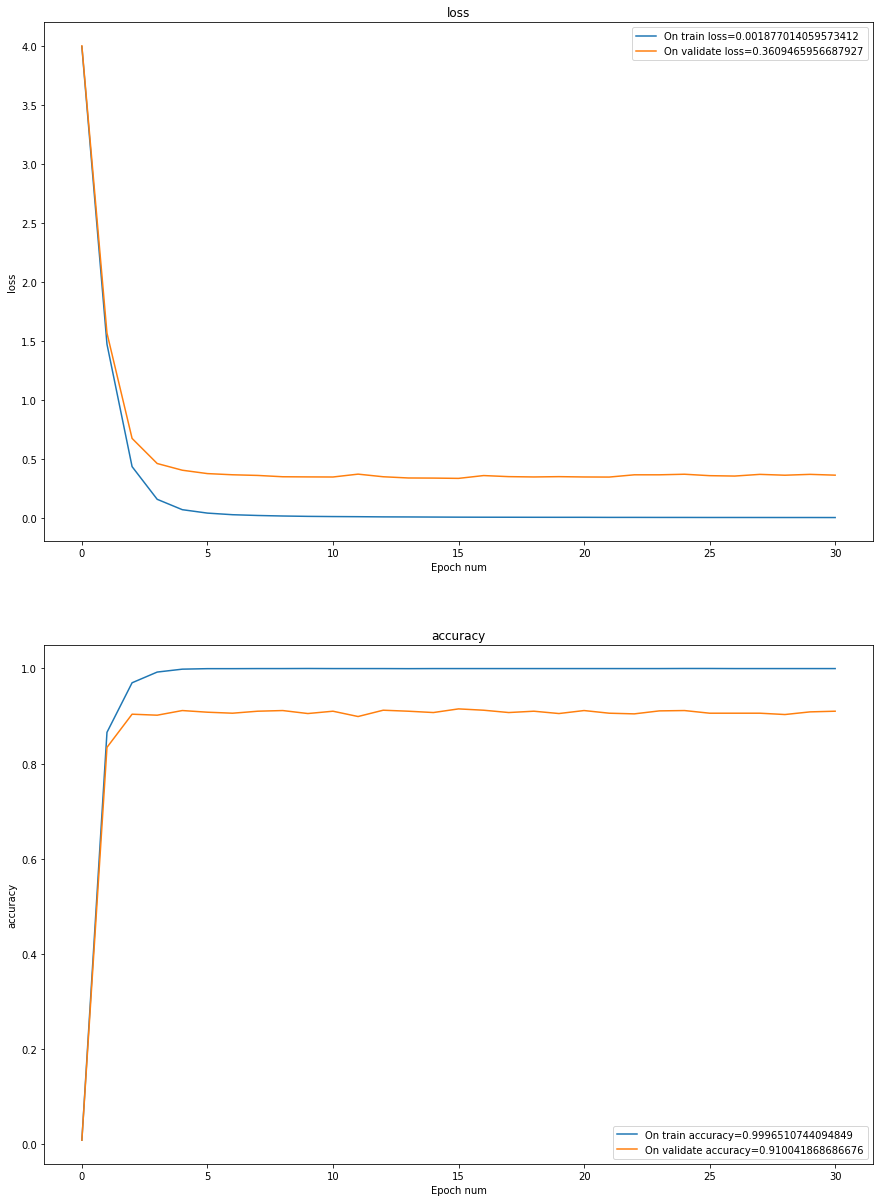

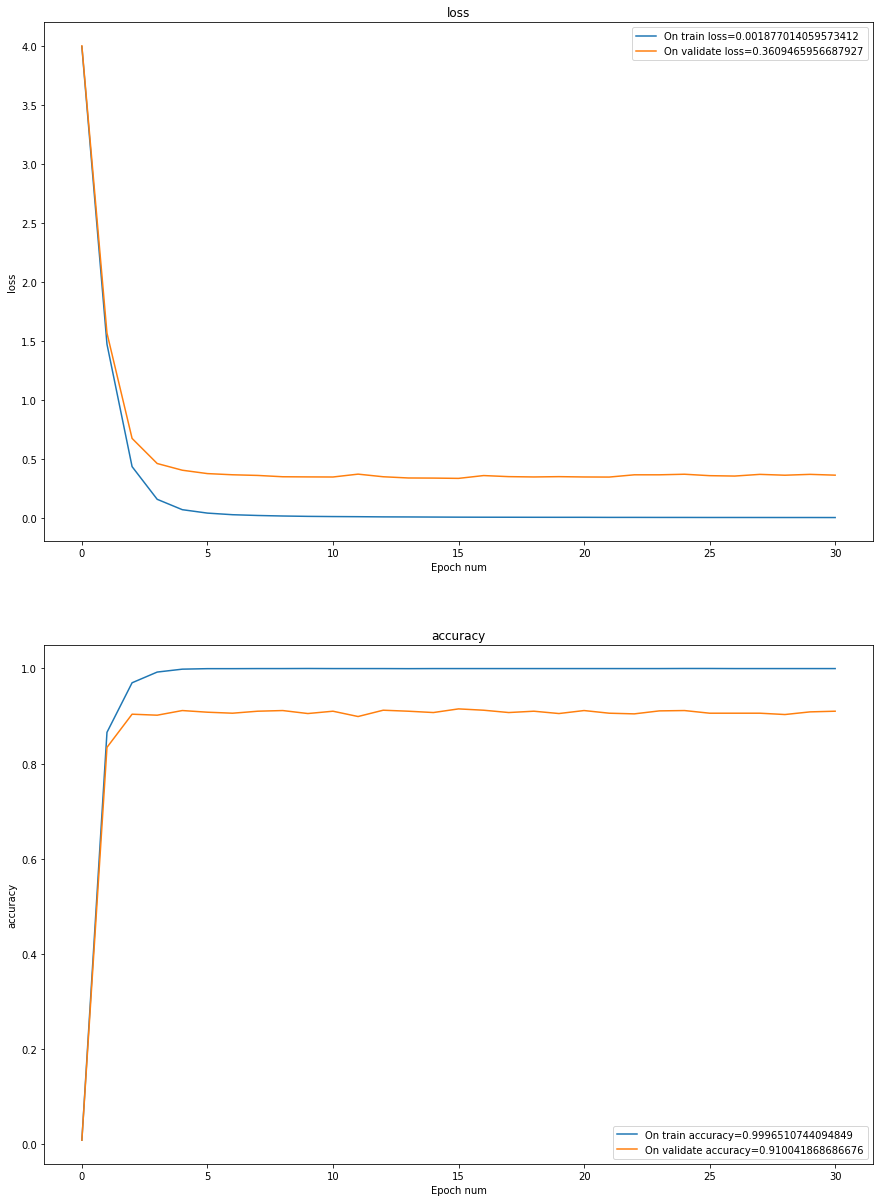

CPU times: user 53min 18s, sys: 17min 33s, total: 1h 10min 51s
Wall time: 1h 10min 55s
CPU times: user 53min 18s, sys: 17min 33s, total: 1h 10min 51s
Wall time: 1h 10min 55s


In [0]:
%%time
resnet50_lm = LearningModel(resnet50, 'ResNet50')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader
}
resnet50_lm.fit(dataloaders, n_epoch=30)

#### Попытаемся дообучить GoogleNet

In [0]:
googlenet = get_googlenet(50).to(device)
torchsummary.summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

Epoch 30/30


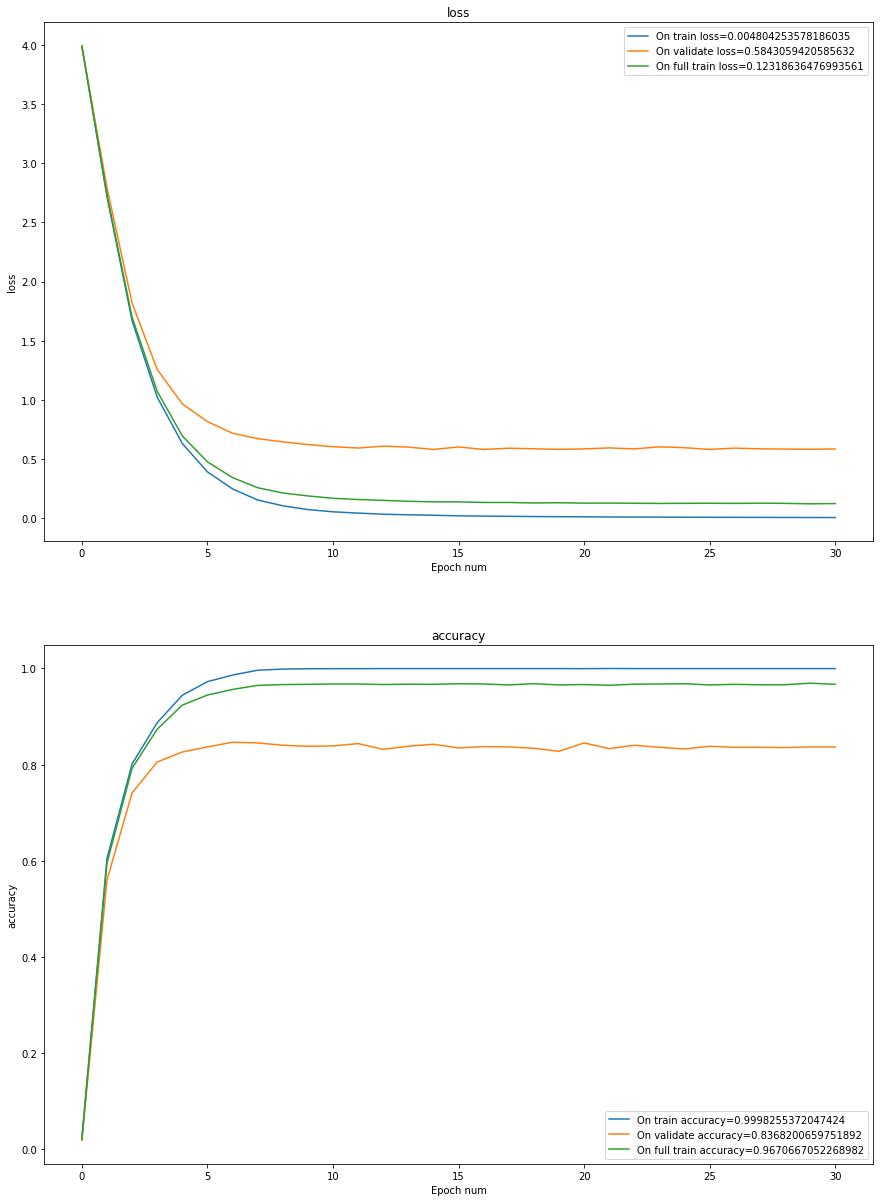

CPU times: user 58min 54s, sys: 9min, total: 1h 7min 54s
Wall time: 1h 7min 55s


In [0]:
%%time
googlenet_lm = LearningModel(googlenet, 'ResNet50')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader,
    'full train' : full_train_loader
}
googlenet_lm.fit(dataloaders, n_epoch=30)

#### И на конец ResNext50

In [0]:
resnext50 = get_resnext50(50).to(device)
torchsummary.summary(resnext50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch 30/30


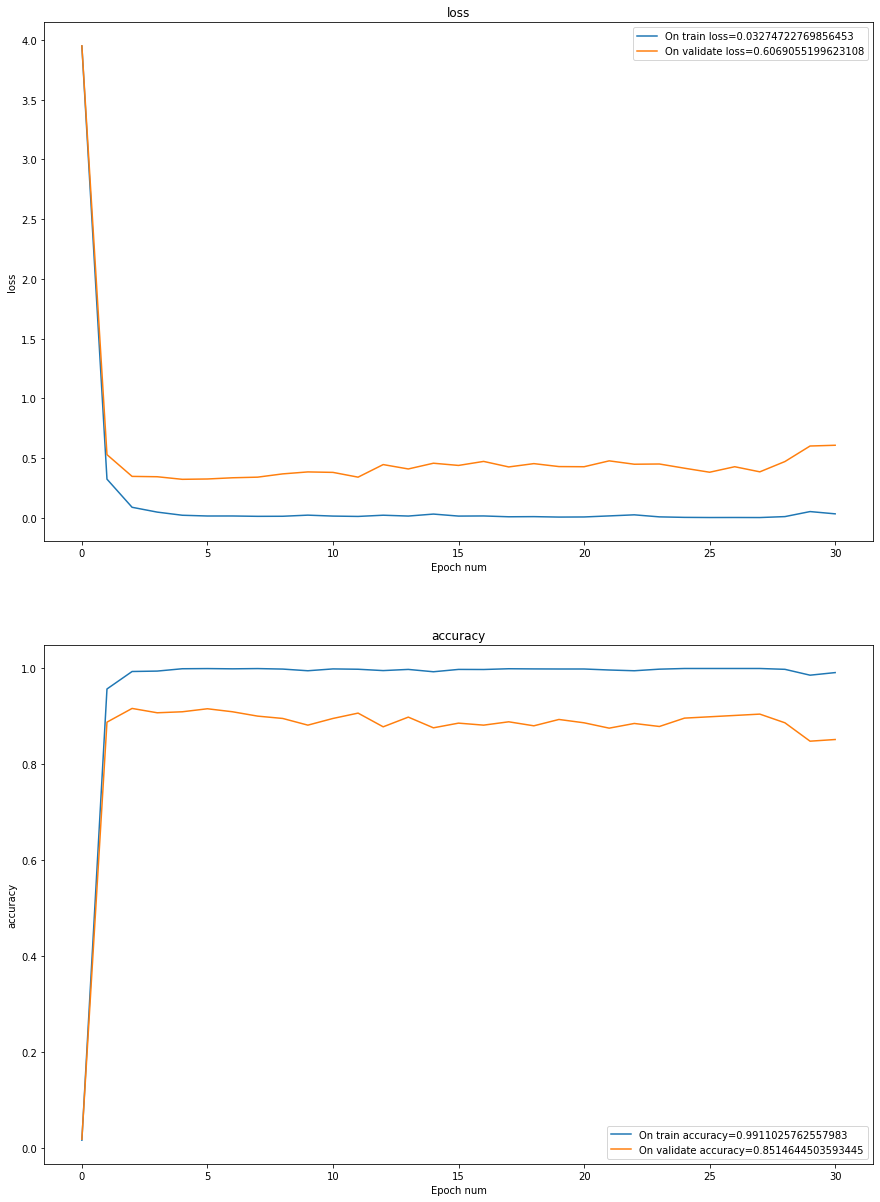

CPU times: user 1h 6min 16s, sys: 22min 46s, total: 1h 29min 3s
Wall time: 1h 29min 7s


In [0]:
%%time
resnext50_lm = LearningModel(resnext50, 'ResNext50')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader
}
resnext50_lm.fit(dataloaders, n_epoch=30)

#### А теперь попробуем обучать только последние слои для ResNet50

In [0]:
resnet50_fixed = get_resnet50_fixed(50).to(device)
torchsummary.summary(resnet50_fixed, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch 60/60


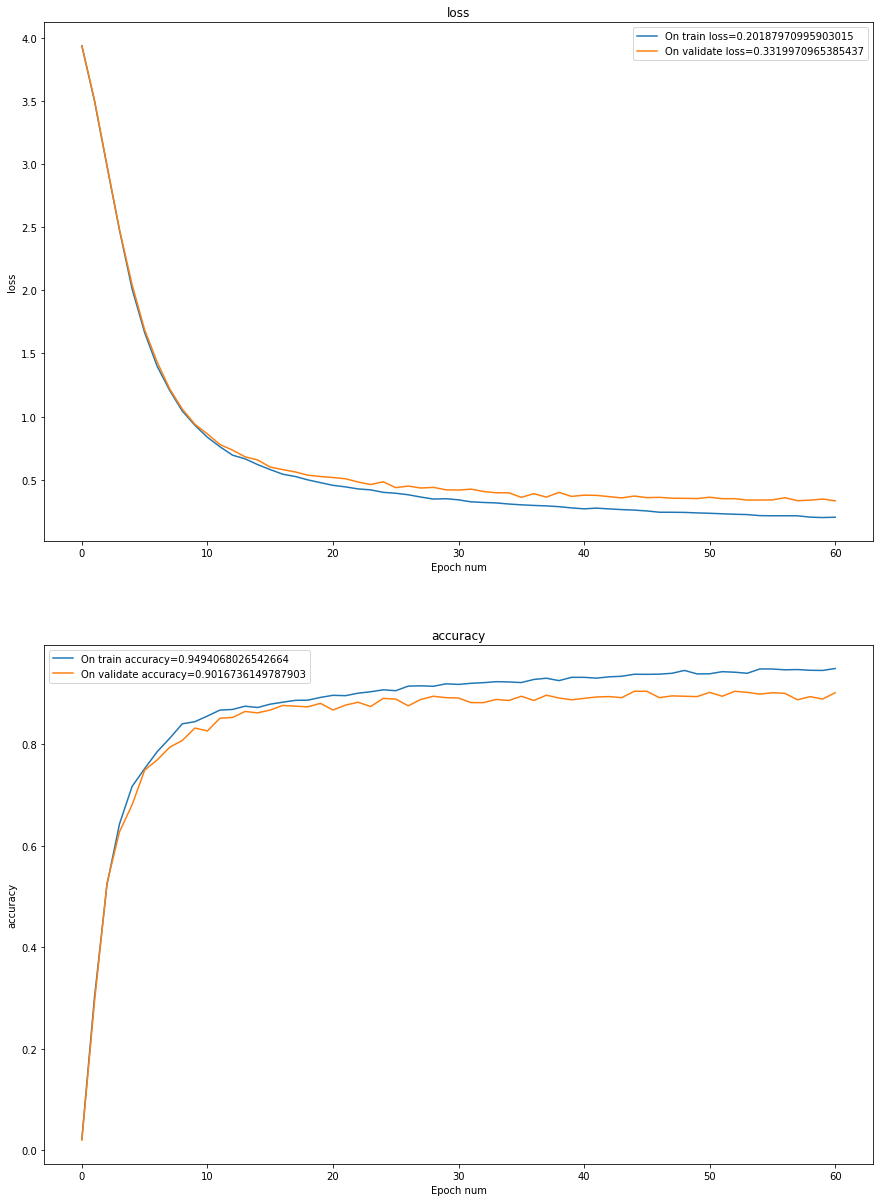

CPU times: user 1h 17min 41s, sys: 6min 7s, total: 1h 23min 48s
Wall time: 1h 23min 53s


In [0]:
%%time
resnet50_fixed_lm = LearningModel(resnet50_fixed, 'ResNet50 fixed')
dataloaders = {
    'train' : train_loader,
    'validate' : validate_loader
}
resnet50_fixed_lm.fit(dataloaders, n_epoch=120)

### Финальное обучение

Было много эксперименттов, сначала я просто зафиксировал lr=1e4 и пробовал разные модели, потом выбрал лучшие - ResNet50 и ResNext50. 

Для них изменил lr на 5e5 и попробовал снова. Немного лучше

Потом я понял, что все модели переобучаются. Исправил это тем, что заморозил первые слои. Решил обучить ResNet50, добавив ещ один полносвязный слой. Получилось неплохо.

Это и будет финальная модель

Epoch 80/80


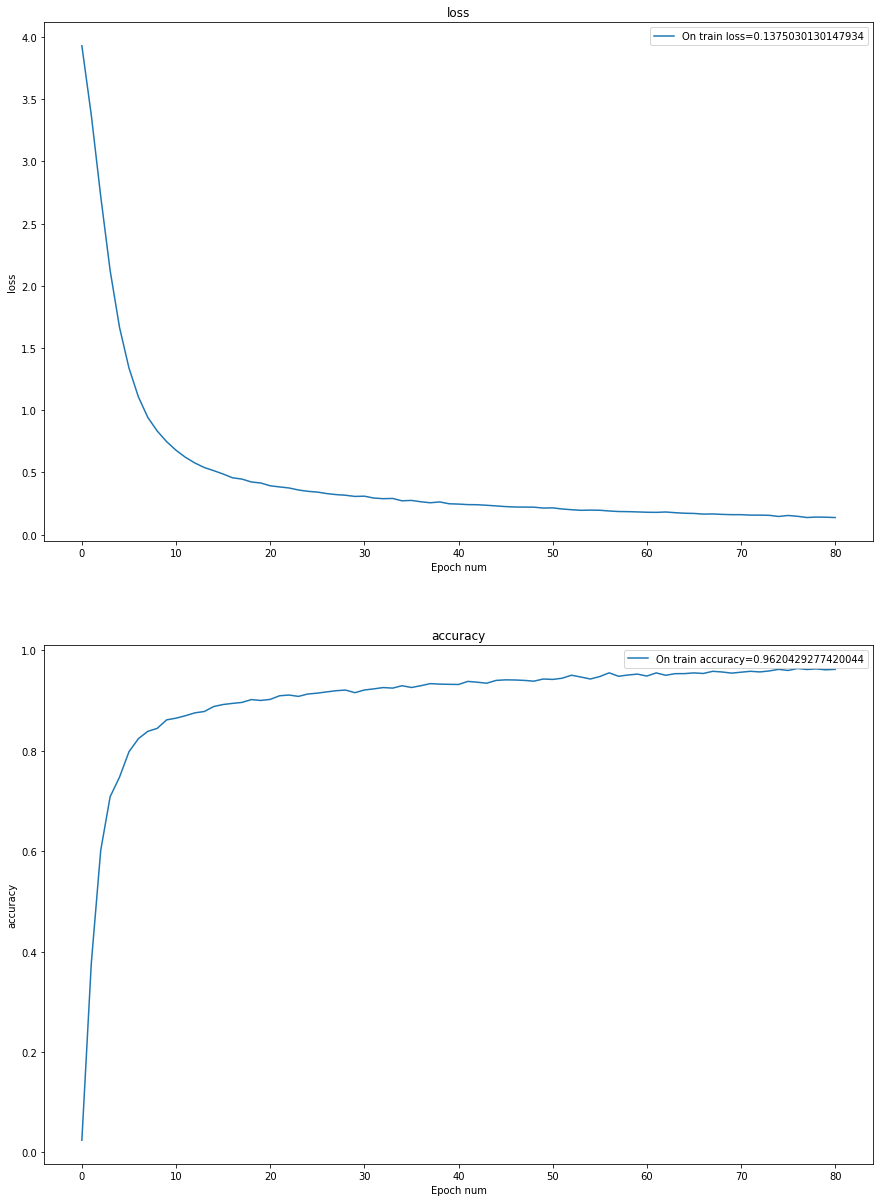

CPU times: user 2h 39min 57s, sys: 29min 36s, total: 3h 9min 33s
Wall time: 3h 9min 40s


In [14]:
%%time
resnet50_fixed = get_resnet50_fixed(50).to(device)
resnet50_fixed_lm = LearningModel(resnet50_fixed, 'ResNet50')
dataloaders = {
    'train' : full_train_loader
}
resnet50_fixed_lm.fit(dataloaders, n_epoch=80)

### Сохранение результатов

In [0]:
solution_file = os.path.join(WORK_DIR, 'results', 'predictions.csv')
with open(solution_file, 'w') as f:
    cw = csv.writer(f, delimiter=',')
    with torch.no_grad():
        for e, name in test_loader:
            e = e.to(device)
            prediction = resnet50_fixed_lm.predict(e)
            cw.writerow([name[0], int(prediction.cpu())])
            # print(name[0], int(prediction.cpu()))
            # break